In [1]:
import tensorflow as tf
import numpy as np

# 导入图形库
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# 加载scikit-learning
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

# 07. 反向传播算法
本章从理论层面学习神经网络中的核心算法之一：`误差反向传播算法`(Backpropagation，简称BP)。

有了深度学习框架自动求导、自动更新参数的功能，算法设计者几乎不需要对反向传播算法有深入的了解也可以搭建复杂的模型和网络，通过调用优化工具可以方便地训练网络模型。但是，`反向传播算法`和`梯度下降算法`是神经网络的核心算法，深刻理解其工作原理十分重要。

## 7.1 导数与梯度
导数定义：
+ $f'(x) = \frac{d\mathcal{y}}{d\mathcal{x}} = \lim_{\triangle x\to 0}\big(\frac{\triangle y}{\triangle x}\big) = \lim_{\triangle x\to 0}\big(\frac{f(x+\triangle x) - f(x)}{\triangle x}\big)$

从几何角度来看，一元函数在某处的导数就是函数的切线在此处的斜率，即函数值沿着$x$方向的变化率。

实际上，导数是一个非常宽泛的概念，只是因为以前接触到的函数大多是一元函数，自变量$\triangle x$只有两个方向：$x^+$和$x^-$。当函数的自变量数大于一个时，函数的导数概念拓展为函数值沿着任意方向的变化率。

导数本身是标量，没有方向，但是导数表征了函数值在某个方向的上变化率。在这些任意方向中，沿着坐标轴的几个方向比较特殊，此时的导数也叫作`偏导数`(Partial Derivative)。多元函数的偏导数是导数的特例，也没有方向。

考虑本质上为多元函数的神经网络模型，比如`shape`为`[784, 256]`的权值矩阵$W$，它包含了$784 \times 256$个连接权值$w$，我们需要求出$784 \times 256$个偏导数。利用梯度下降算法优化网络时，需要求出网络的所有偏导数。因此，我们关心的也是误差函数输出$\mathcal{L}$沿着自变量$\theta_i$方向上的导数，即$\mathcal{L}$对网络参数$\theta_i$的偏导数：
+ $\nabla_\theta \mathcal{L} = \big(\displaystyle\frac{\partial \mathcal{L}}{\partial \theta_1},\frac{\partial \mathcal{L}}{\partial \theta_2},\frac{\partial \mathcal{L}}{\partial \theta_3},\dots \frac{\partial \mathcal{L}}{\partial \theta_n}\big)$

梯度下降算法可以按着向量形式进行更新：
+ $\theta' = \theta - \mu\cdot\nabla_\theta\mathcal{L}$

$\mu$是学习率。

这里把向量$\big(\displaystyle\frac{\partial \mathcal{L}}{\partial \theta_1},\frac{\partial \mathcal{L}}{\partial \theta_2},\frac{\partial \mathcal{L}}{\partial \theta_3},\dots \frac{\partial \mathcal{L}}{\partial \theta_n}\big)$称为函数的梯度(Gradient)，它由所有偏导数组成，表征方向。

通过梯度下降算法并不能保证得到全局最优解，这主要是目标函数的非凸性造成的。 

神经网络模型的参数量可达千万、数亿级别，几乎所有的神经网络的优化问题都是依赖于深度学习框架去自动计算网络参数的梯度，然后采用梯度下降算法循环迭代优化网络的参数直至性能满足需求。深度学习框架这里主要实现的算法就是反向传播算法和梯度下降算法，因此理解这两个算法的原理有利于了解深度学习框架的作用。

在介绍反向传播算法之前，我们先介绍导数的常见属性，常见激活函数、损失函数的梯度推导，然后再推导多层神经网络的梯度传播规律。

## 7.2 导数常见性质
[略]

## 7.3 激活函数导数
这里介绍神经网络中常用的激活函数的导数推导。

### 7.3.1 Sigmoid 函数导数
`Sigmoid`函数表达式：
+ $\sigma(x) = \displaystyle\frac{1}{1+e^{-x}}$

导数为：
+ $\displaystyle\frac{d\sigma(x)}{d\mathcal{x}}=\frac{d}{d\mathcal{x}}\big(\frac{1}{1+e^{-x}}\big) = \frac{e^{-x}}{(1+e^{-x})^2} = \frac{(1+e^{-x})-1}{(1+e^{-x})^2} = \frac{(1+e^{-x})}{(1+e^{-x})^2} - \frac{1}{(1+e^{-x})^2} = \sigma(x)-\sigma(x)^2$

<img src="images/07_02.png" style="width:300px;"/>

### 7.3.2 ReLU 函数导数
`ReLU`函数的表达式：
+ $\mathcal{ReLU}(x) = \max(0, x)$

导数为：
+ $\displaystyle \frac{d}{d\mathcal{x}}\mathcal{ReLU} = \begin{cases} 1, & x \ge 0\\ 0, & x \lt 0 \end{cases}$

$\mathcal{ReLU}$函数的导数在$x$大于等于零的时候恒为1，在反向传播过程中，它既不会放大梯度，造成`梯度爆炸`现象；也不会缩小梯度，造成`梯度弥散`现象。

<img src="images/07_03.png" style="width:300px;"/>

在$\mathcal{ReLU}$函数被广泛应用之前，神经网络中激活函数采用`Sigmoid`居多，但是`Sigmoid`函数容易出现`梯度弥散`现象(参考`sigmoid`导数的曲线)，当网络的层数增加后，较前层的参数由于梯度值非常微小，参数长时间得不到有效更新，无法训练较深层的神经网络，导致神经网络的研究一直停留在浅层。$\mathcal{ReLU}$函数很好地缓解了梯度弥散的现象，神经网络的层数能够地达到较深层数，如`AlexNet`中采用了`ReLU`激活函数，层数达到了8层，后续提出的上百层的卷积神经网络也多是采用$\mathcal{ReLU}$激活函数。

### 7.3.3 LeakyReLU函数导数
`LeakyReLU`函数的表达式：
+ $\displaystyle \mathcal{LeakyReLU} = \begin{cases} x, & x \ge 0\\ px, & x \lt 0 \end{cases}$

导数为：
+ $\displaystyle \frac{d}{d\mathcal{x}}\mathcal{LeakyReLU} = \begin{cases} 1, & x \ge 0\\ 0, & p \lt 0 \end{cases}$

<img src="images/07_04.png" style="width:330px;"/>

### 7.3.4 Tanh函数梯度
`tanh`函数的表达式：
+ $\tanh(x) = \displaystyle\frac{(e^x-e^{-x})}{(e^x+e^{-x})} = 2 \cdot \text{sigmoid}(2x)−1$

导数为：
+ $\displaystyle \frac{d}{d\mathcal{x}}\mathcal{tanh} = 1-\mathcal{tanh}^2(x)$

<img src="images/07_05.png" style="width:300px;"/>

## 7.4 损失函数梯度
### 7.4.1 均方误差函数梯度
均方误差损失函数表达式为：
+ $\mathcal{L} = \displaystyle\frac{1}{2}\sum_{k=1}^{K}(y_k-o_k)^2$

上式中的$\frac{1}{2}$项用于简化计算，也可以利用$\frac{1}{K}$进行平均，这些缩放运算均不会改变梯度方向。

偏导数为：
+ $\displaystyle\frac{\partial \mathcal{L}}{\partial o_i} = \frac{1}{2}\sum_{k=1}^{K}\frac{\partial}{\partial o_i}(y_k-o_k)^2 = \sum_{k=1}^{K}(y_k-o_k)\frac{\partial (y_k-o_k)}{\partial o_i} = \sum_{k=1}^{K}(y_k-o_k)\cdot (-1)\cdot\frac{\partial o_k}{\partial o_i} = \sum_{k=1}^{K}(o_k-y_k)\frac{\partial o_k}{\partial o_i}$

考虑到$\displaystyle\frac{\partial o_k}{\partial o_i}$仅当$k=i$时才为1，其它点都为0，均方误差函数的导数可以推导为：
+ $\displaystyle\frac{\partial \mathcal{L}}{\partial o_i} = (o_i-y_i)$

### 7.4.2 交叉熵函数梯度
参考[文章](https://www.yuque.com/zealotcat/gt9fc2/ru2i66)

在计算交叉熵损失函数时，一般将`Softmax`函数与交叉熵函数统一实现。我们先推导`Softmax`函数的梯度，再推导交叉熵函数的梯度。 

`Softmax`函数的表达式：
+ $\mathcal{Softmax}(z_i) = \displaystyle\frac{e^{z_i}}{\sum_{j=1}^{d_{out}}e^{z_j}}$

<img src="images/06_14.png" style="width:300px;"/>

回顾导数的常见性质，复合函数$\displaystyle f(x) = \frac{g(x)}{h(x)}$的导数为$\displaystyle f'(x) = \frac{g'(x)h(x)-h'(x)g(x)}{h(x^2)}$。对于`Softmax`函数，$g(x)=e^{z_i}, h(x)=\sum_{k=1}^{K}e^{z_k}$。

我们利用这个性质，并且根据$i == j$和$i \ne j$分别对`Softmax`函数进行求导。

##### 当`i==j`时
有$\displaystyle\frac{\partial e^{z_i}}{\partial z_j} = e^{z_i}$，因此：

+ $\displaystyle\frac{\partial p_i}{\partial z_j} = \frac{\partial\displaystyle\frac{e^{z_j}}{\sum_{k=1}^{K}e^{z_k}}}{\partial z_j} = \frac{e^{z_j}\sum_{k=1}^{K}e^{z_k}-e^{z_j}e^{z_i}}{(\sum_{k=1}^{K}e^{z_k})^2} = \frac{e^{z_j}\big(\sum_{k=1}^{K}e^{z_k}-e^{z_i}\big)}{(\sum_{k=1}^{K}e^{z_k})^2} = \frac{e^{z_j}}{\sum_{k=1}^{K}e^{z_k}}\times\frac{\big(\sum_{k=1}^{K}e^{z_k}-e^{z_i}\big)}{\sum_{k=1}^{K}e^{z_k}}$

我们知道，所有的概率相加为1，即$\sum_{k=1}^{K}e^{z_k} = 1$，所以：
+ $\displaystyle\frac{\partial p_i}{\partial z_j} = p_i(1-p_j), \ i==j$

##### 当`i!=j`时
有$\displaystyle\frac{\partial e^{z_i}}{\partial z_j} = 0$，因此：

+ $\displaystyle\frac{\partial p_i}{\partial z_j} = \frac{\partial\displaystyle\frac{e^{z_j}}{\sum_{k=1}^{K}e^{z_k}}}{\partial z_j} = \frac{e^{z_j}\sum_{k=1}^{K}e^{z_k}-e^{z_j}e^{z_i}}{(\sum_{k=1}^{K}e^{z_k})^2} = \frac{0-e^{z_j}e^{z_i}}{(\sum_{k=1}^{K}e^{z_k})^2} = \frac{-e^{z_j}}{\sum_{k=1}^{K}e^{z_k}}\times \frac{e^{z_i}}{\sum_{k=1}^{K}e^{z_k}} = -p_ip_j$

因此得出`Softmax`函数的偏导数如下：
+ $\displaystyle\frac{\partial p_i}{\partial z_j} = \begin{cases} p_i(1-p_j), &  i==j \\ -p_i\cdot p_j, & i \ne j \end{cases}$

##### 交叉熵梯度
交叉熵损失函数的表达式：
+ $\mathcal{L} = \displaystyle − \sum_{k}y_k\log{(p_k)}$

这里直接推导$\mathcal{L}$对网络输出的$\mathcal{logits}$变量$z_i$的偏导数：
+ $\displaystyle \frac{\partial \mathcal{L}}{\partial z_i} = -\sum_{k}y_k\frac{\partial \log(p_k)}{\partial z_i}$

将$\log{h}$复合函数分解后得到：
+ $\displaystyle \frac{\partial \mathcal{L}}{\partial z_i} = -\sum_{k}y_k\cdot\frac{\partial \log(p_k)}{\partial p_k}\cdot \frac{\partial p_k}{\partial z_i} = -\sum_{k}y_k\cdot\frac{1}{p_k}\cdot \frac{\partial p_k}{\partial z_i}$

其中，$\displaystyle\frac{\partial p_k}{\partial z_i}$就是我们已经推导的`Softmax`函数的偏导数。将求和符号拆分为$k==i$和$k!=i$两种情况，代入`Softmax`函数的偏导数可得：
+ $\displaystyle \frac{\partial \mathcal{L}}{\partial z_i} = -y_i(1-p_i)-\sum_{k\ne i}y_k\cdot\frac{1}{p_k}(-p_kp_i) = -y_i(1-p_i)+\sum_{k\ne i}y_k\cdot p_i = -y_i+y_ip_i+\sum_{k\ne i}y_k\cdot p_i = p_i\big(y_i+\sum_{k\ne i}y_k\big)-y_i$

特别的，对于分类问题中标签$y$通过`onehot`编码的方式，则有如下关系：
+ $\displaystyle\sum_{k}y_k = 1$
+ $\displaystyle y_i+\sum_{k\ne i}y_k = 1$

因此交叉熵的偏导数可以进一步简化为：
+ $\displaystyle \frac{\partial \mathcal{L}}{\partial z_i} = p_i-y_i$

## 7.5 全连接层梯度
本节介绍神经网络的反向传播算法的推导。实际使用的神经网络的结构多种多样，我们将以全连接层网络、激活函数采用`Sigmoid`函数、误差函数为`Softmax+MSE`损失函数的神经网络为例，推导其梯度传播规律。

### 7.5.1 单神经元梯度
对于采用`Sigmoid`激活函数的神经元模型，它的数学模型可以写为：
+ $o^{(1)} = \sigma({w^{(1)}}^Tx + b^{(1)})$

其中变量的上标表示层数，如$o^{(1)}$表示第一层的输出，$x$表示网络的输入，我们以权值参数$w_{j1}$的偏导数$\displaystyle\frac{\partial \mathcal{L}}{\partial w_{j1}}$推导为例。

神经元模型如`图7.7`所示，输入节点数为$\mathcal{J}$。其中输入第$j$个节点到输出$o^{(1)}$的权值连接记为$w_{j1}^{(1)}$，上标表示权值参数属于的层数，下标表示当前连接的起始节点号和终止节点号，如$j1$表示上一层的第$j$号节点到当前层的第1号节点。经过激活函数$\sigma$之前的变量叫做$z_1^{(1)}$，经过激活函数$\sigma$之后的变量叫$o_1^{(1)}$，由于只有一个输出节点，故$o_1^{(1)} = o^{(1)} = o$。输出与真实标签之间通过误差函数函数计算误差值，误差值记为$\mathcal{L}$。

<img src="images/07_07.png" style="width:450px;"/>

如果我们采用均方误差函数，考虑到单个神经元只有一个输出，那么损失可以表达为：
+ $\mathcal{L} = \frac{1}{2}\big(o_1-t\big)^2$

其中$t$为真实标签值，添加$\frac{1}{2}$项使得计算更简便，不影响梯度的方向。我们以权重变量$w_{j1}$为例计算损失函数的导数：
+ $\displaystyle\frac{\partial \mathcal{L}}{\partial w_{j1}} = (o_1-t)\frac{\partial o_1}{\partial w_{j1}} = (o_1-t)\frac{\partial \sigma(z_1)}{\partial w_{j1}}$

代入`Sigmoid`函数的导数$\sigma'=\sigma(1-\sigma)$：
+ $\displaystyle\frac{\partial \mathcal{L}}{\partial w_{j1}} = (o_1-t)\sigma(z_1)(1-\sigma(z_1))\frac{\partial \sigma(z_i)}{\partial w_{j1}} = (o_1-t)\cdot o_1\cdot(1-o_1)\frac{\partial \sigma(z_i)}{\partial w_{j1}}$

由于$\frac{\partial \sigma(z_i)}{\partial w_{j1}} = x_j$，代入得到：
+ $\displaystyle\frac{\partial \mathcal{L}}{\partial w_{j1}} = (o_1-t)\cdot o_1\cdot(1-o_1)x_j$

从上式可以看到，误差对权值$w_{j1}$的偏导数只与输出值$o_1$ 、真实值$t$以及当前权值连接的输入$x$有关。

### 7.5.2 全连接层梯度
我们把单个神经元模型推广到单层的全连接层的网络上，如`图7.8`所示。输入层通过一个全连接层得到输出向量，与真实标签向量计算均方误差。输入节点数为$J$，输出节点数为$K$。

<img src="images/07_08.png" style="width:450px;"/>

多输出的全连接网络层模型与单个神经元模型不同之处在于，它多了很多的输出节点$o_1^{(1)},o_2^{(1)},o_3^{(1)},\dots,o_K^{(1)}$，每个输出节点分别对应到真实标签$t_1,t_2,t_3,\dots,t_k$。$w_{jk}$是输入第$j$号节点与输出第$k$号节点的连接权值。均方误差可以表达为：
+ $\mathcal{L} = \displaystyle\frac{1}{2}\sum_{i=1}^{K}\big(o_i^{(1)}-t_i\big)^2$

由于$\displaystyle\frac{\partial \mathcal{L}}{\partial w_{jk}}$只与节点$o_k^{(1)}$有关联，上式中的求和符号可以去掉，即$i=k$：
+ $\displaystyle\frac{\partial \mathcal{L}}{\partial w_{jk}} = (o_k-t_k)\frac{\partial o_k}{\partial w_{jk}} = (o_k-t_k)\frac{\partial \sigma(z_k)}{\partial w_{jk}}$

在代入`Sigmoid`函数的导数：
+ $\displaystyle\frac{\partial \mathcal{L}}{\partial w_{jk}} = (o_k-t_k)\cdot\sigma(z_k)\cdot(1-\sigma(z_k))\frac{\partial z_k^{(1)}}{\partial w_{jk}}$

代入$\sigma(z_k)=o_k$、$\displaystyle\frac{\partial z_k^{(1)}}{\partial w_{jk}}=x_j$，得到：
+ $\displaystyle\frac{\partial \mathcal{L}}{\partial w_{jk}} = (o_k-t_k)\cdot o_k\cdot(1-o_k)x_j$

由此可以看到，某条连接$w_{jk}$上面的偏导数，只与当前连接的输出节点$o_k^{(1)}$、对应的真实值节点的标签$t_k^{(1)}$、以及对应的输入节点$x$有关。

我们令$\delta_k = (o_k-t_k)\cdot o_k\cdot(1-o_k)$，则梯度可以表达为：
+ $\displaystyle\frac{\partial \mathcal{L}}{\partial w_{jk}} =\delta_k\cdot x_j$

其中$\delta_k$变量表征连接线的终止节点的误差梯度传播的某种特性，使用$\delta_k$表示后，偏导数只与当前连接的起始节点$x_j$，终止节点处$\delta_k$有关，理解起来比较简洁直观。后续我们将会在看到$\delta_k$在循环推导梯度中的作用。

现在已经推导完单层神经网络(即输出层)的梯度传播方式，接下来我们尝试推导倒数第二层的梯度传播方式。完成了倒数第二层的传播推导后，就可以类似地，循环往复推导所有隐藏层的梯度传播方式，从而获得所有层参数的梯度计算表达式。

在介绍反向传播算法之前，我们先学习导数传播的一个核心法则：**链式法则**。

## 7.6 链式法则
链式法则可以在不显式推导神经网络的数学表达式的情况下，逐层推导梯度的核心公式，非常重要。

考虑$y = f(u)，u = g(x)$，则：
+ $\displaystyle\frac{dy}{dx} = \frac{dy}{du}\cdot\frac{du}{dx} = f'(g(x))g'(x)$

神经网络的损失函数$\mathcal{L}$来自于各个输出节点$o_k^{K}$，如`图7.9`所示，其中输出节点$o_k^{K}$又与隐藏层的输出节点$o_j^{J}$相关联，因此链式法则非常适合于神经网络的梯度推导。

<img src="images/07_09.png" style="width:400px;"/>

我们分析一下损失函数$\mathcal{L}$如何应用链式法则。前向传播时，数据经过$w_{ij}^{(J)}$传到倒数第二层的节点$o_j^{(J)}$，再传播到输出层的节点$o_k^{(K)}$。在每层只有一个节点时，$\displaystyle\frac{\partial \mathcal{L}}{\partial w_{ij}^{(J)}}$可以利用链式法则，逐层分解为：
+ $\displaystyle\frac{\partial \mathcal{L}}{\partial w_{ij}^{(J)}} = \displaystyle\frac{\partial \mathcal{L}}{\partial o_j^{(J)}}\cdot\frac{\partial o_j^{(J)}}{\partial w_{ij}^{(J)}} = \frac{\partial \mathcal{L}}{\partial o_k^{(K)}}\cdot\frac{\partial o_k^{(K)}}{\partial o_j^{(J)}}\cdot\frac{\partial o_j^{(J)}}{\partial w_{ij}^{(J)}}$

其中$\displaystyle\frac{\partial L}{\partial o_k^{(K)}}$可以由误差函数直接推导出，$\displaystyle\frac{\partial o_k^{(K)}}{\partial o_j^{(J)}}$可以由全连接层公式推导出，$\displaystyle\frac{\partial o_j^{(J)}}{\partial w_{ij}^{(J)}}$的导数即为输入$x_i^{(I)}$。可以看到，通过链式法则，我们将偏导数进行分解，层层迭代即可推导出。

这里简单使用`TensorFlow`自动求导功能，来体验链式法则的魅力：

In [2]:
# 构建待优化变量
x = tf.constant(1.)
w1 = tf.constant(2.)
b1 = tf.constant(1.)
w2 = tf.constant(2.)
b2 = tf.constant(1.)

# 构建梯度记录器
with tf.GradientTape(persistent=True) as tape:
    # 非tf.Variable类型的张量需要人为设置记录梯度信息
    tape.watch([w1, b1, w2, b2])
    # 构建2层线性网络
    y1 = x * w1 + b1
    y2 = y1 * w2 + b2

# 独立求解出各个偏导数
dy2_dy1 = tape.gradient(y2, [y1])[0]
dy1_dw1 = tape.gradient(y1, [w1])[0]
dy2_dw1 = tape.gradient(y2, [w1])[0]

# 验证链式法则，2个输出应相等
print(dy2_dy1 * dy1_dw1)
print(dy2_dw1)

tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)


可以看到，$\displaystyle\frac{\partial y_2}{\partial y_1}\cdot\frac{\partial y_1}{\partial w_1} = \frac{\partial y_2}{\partial w_1}$，偏导数的传播是符合链式法则的。

## 7.7 反向传播算法
现在我们来推导隐藏层的梯度传播规律。简单回顾一下输出层的偏导数公式：
+ $\displaystyle\frac{\partial \mathcal{L}}{\partial w_{jk}} = (o_k-t_k)\cdot o_k\cdot(1-o_k)x_j = \delta_k\cdot x_j$

考虑倒数第二层的偏导数$\displaystyle\frac{\partial \mathcal{L}}{\partial w_{ij}}$，如`图7.10`所示，输出层节点数为$\mathrm{K}$，输出为$o^{(K)} = \big[o_1^{(K)},o_2^{(K)},\dots,o_K^{(K)}\big]$；倒数第二层节点数为$\mathrm{J}$，输出为$o^{(J)} = \big[o_1^{(J)},o_2^{(J)},\dots,o_J^{(J)}\big]$；倒数第三层的节点数为$\mathrm{I}$，输出为$o^{(I)} = \big[o_1^{(I)},o_2^{(I)},\dots,o_I^{(I)}\big]$。

<img src="images/07_10.png" style="width:500px;"/>

为了表达简洁，部分变量的上标有时会省略掉。首先将均方误差函数展开：
+ $\displaystyle\frac{\partial \mathcal{L}}{\partial w_{ij}} = \frac{\partial}{\partial w_{ij}}\frac{1}{2}\sum_{k}\big(o_k-t_k\big)^2$

由于$\mathcal{L}$通过每个输出节点$o_k$与$w_i$相关联，故此处不能去掉求和符号，运用链式法则将均方差函数拆解：
+ $\displaystyle\frac{\partial \mathcal{L}}{\partial w_{ij}} = \sum_{k}(o_k-t_k)\frac{\partial}{\partial w_{ij}}o_k = \sum_{k}(o_k-t_k)\frac{\partial}{\partial w_{ij}}\sigma(z_k)$

利用`Sigmoid`函数的导数进一步解析：
+ $\displaystyle\frac{\partial \mathcal{L}}{\partial w_{ij}} = \sum_{k}(o_k-t_k)\sigma(z_k)(1-\sigma(z_k))\frac{\partial z_k}{\partial w_{ij}} = \sum_{k}(o_k-t_k)\cdot o_k\cdot(1-o_k)\frac{\partial z_k}{\partial o_j}\cdot \frac{\partial o_j}{\partial w_{ij}}$

由于$\displaystyle\frac{\partial z_k}{\partial o_j} = w_{jk}$、$\displaystyle\frac{\partial o_j}{\partial w_{ij}}$与$k$无关，上式可以简化成：
+ $\displaystyle\frac{\partial \mathcal{L}}{\partial w_{ij}} = \frac{\partial o_j}{\partial w_{ij}}\sum_{k}(o_k-t_k)\cdot o_k\cdot(1-o_k)w_{jk}$

进一步利用$o_j = \sigma(z_j)$、并利用`Sigmoid`函数的导数推导：
+ $\displaystyle\frac{\partial \mathcal{L}}{\partial w_{ij}} = o_j(1-o_j)\frac{\partial \mathcal{z_j}}{\partial w_{ij}}\sum_{k}(o_k-t_k)\cdot o_k\cdot(1-o_k)w_{jk}$

其中，$\displaystyle\frac{\partial z_j}{\partial w_{ij}}$的导数可以直接推导为$o_i$，上式可以写为：
+ $\displaystyle\frac{\partial \mathcal{L}}{\partial w_{ij}} = o_j(1-o_j)o_i\sum_{k}(o_k-t_k)\cdot o_k\cdot(1-o_k)w_{jk}$

我们令$\sigma_{k}^{(K)} = (o_k-t_k)o_k(1-o_k)$，则上式简写为：
+ $\displaystyle\frac{\partial \mathcal{L}}{\partial w_{ij}} = o_j(1-o_j)o_i\sum_{k}\sigma_{k}^{(K)}w_{jk}$

类似的，仿照输出层$\displaystyle\frac{\partial \mathcal{L}}{\partial w_{jk}} = \delta_{k}^{(K)}x_j$的书写形式，将$\delta_j^J$定义为：
+ $\displaystyle\delta_j^J \triangleq o_j(1-o_j)\sum_{k}\delta_{k}^{(K)}w_{jk}$

此时$\displaystyle\frac{\partial \mathcal{L}}{\partial w_{ij}}$可以写为当前连接的起始节点的输出值$o_i$与终止节点𝑗的梯度变量信息$\sigma_j^J$的简单相乘运算：
+ $\displaystyle\frac{\partial \mathcal{L}}{\partial w_{ij}} = \delta_j^Jo_i^{(I)}$

可以看到，通过定义$\delta$变量，每一层的梯度表达式变得更加清晰简洁，其中$\delta$可以简单理解为当前连接$w_{ij}$对误差函数的贡献值。 

**我们来小结一下每层的偏导数的传播规律**。

输出层：
+ $\displaystyle\frac{\partial \mathcal{L}}{\partial w_{jk}} = \delta_k^{(K)}o_j$
+ $\delta_k^{(K)}=o_k(1-o_k)(o_k-t_k)$

倒数第二层层：
+ $\displaystyle\frac{\partial \mathcal{L}}{\partial w_{ij}} = \delta_j^{(J)}o_i$
+ $\delta_j^{(J)}=o_j(1-o_j)\sum_{k}\delta_k^{(K)}w_{jk}$

倒数第三层：
+ $\displaystyle\frac{\partial \mathcal{L}}{\partial w_{ni}} = \delta_j^{(I)}o_n$
+ $\delta_i^{(I)}=o_i(1-o_i)\sum_{j}\delta_j^{(J)}w_{ij}$

其中$o_n$为倒数第三层的输入，即倒数第四层的输出。

依照此规律，只需要循环迭代计算每一层每个节点的$\delta_k^{(K)}、\delta_j^{(J)}、\delta_i^{(I)}$等值即可求得当前层的偏导数，从而得到每层权值矩阵$W$的梯度，再通过梯度下降算法迭代优化网络参数即可。

接下来我们通过两个案例演示BP算法：第一个实例通过`TensorFlow`提供的自动求导来优化`Himmelblau`函数的极值；第二个是基于`Numpy`实现反向传播算法，并完成多层神经网络的二分类任务训练。

## 7.8 Himmelblau函数优化实战
`Himmelblau`函数是用来测试优化算法的常用样例函数之一，它包含了两个自变量$x$和$y$，数学表达式是：
+ $f(x, y) = (x^2+y−11)^2+(x+y^2−7)^2$

首先生成函数的图像：

x,y range: (120,) (120,)
X,Y maps: (120, 120) (120, 120)


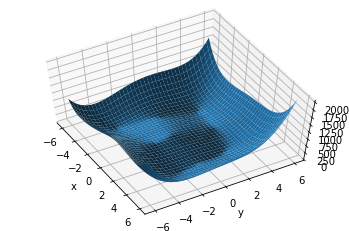

In [3]:
def himmelblau(x):
    # himmelblau函数实现，传入参数x为2个元素的List
    return (x[0]**2+x[1]-11)**2 + (x[0]+x[1]**2-7)**2

# 绘制函数图形
x = np.arange(-6, 6, 0.1) # 可视化的x坐标范围为-6~6
y = np.arange(-6, 6, 0.1) # 可视化的y坐标范围为-6~6
print('x,y range:', x.shape, y.shape)

# 生成x-y平面采样网格点，方便可视化
X, Y = np.meshgrid(x, y)
print('X,Y maps:', X.shape, Y.shape)

# 计算网格点上的函数值
Z = himmelblau([X, Y])

# 绘制 himmelblau 函数曲面
fig = plt.figure('himmelblau')
ax = fig.gca(projection='3d') # 设置3D坐标轴
ax.plot_surface(X, Y, Z) # 3D曲面图
ax.view_init(60, -30)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

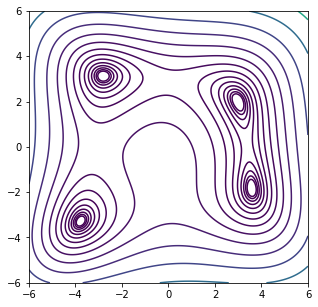

In [4]:
npts = 201
x1, y1 = np.mgrid[-6:6:npts*1j, -6:6:npts*1j]
z1 = himmelblau([x1, y1])

fig = plt.figure(figsize=(5, 5))
levels = np.logspace(0.3, 3.5, 15)
plt.contour(x1, y1, z1, levels, cmap="viridis")
# plt.xlabel(r"$x$", fontsize=14)
# plt.ylabel(r"$y$", fontsize=14)
# plt.xticks([-6, -3, 0, 3, 6])
# plt.yticks([-6, -3, 0, 3, 6])
# plt.xlim([-6, 6])
# plt.ylim([-6, 6])
plt.show()

从`Himmelblau`函数的等高线图可以看出，它共有4个并且局部极小值都是0，所以这4个局部极小值也是全局最小值。我们可以通过解析的方法计算出局部极小值的精确坐标，它们分别是：`(3,2), (−2.805, 3.131), (−3.779, −3.283), (3.584, −1.848)`。

利用`TensorFlow`自动求导来更新$x$和$y$值：

In [5]:
# 参数的初始化值对优化的影响不容忽视，可以通过尝试不同的初始化值，
# 检验函数优化的极小值情况
# [1., 0.], [-4, 0.], [4, 0.]
x = tf.constant([4., 0.]) # 初始化参数
for step in range(200):# 循环优化200次
    with tf.GradientTape() as tape: #梯度跟踪
        tape.watch([x]) # 加入梯度跟踪列表
        y = himmelblau(x) # 前向传播
    # 反向传播
    grads = tape.gradient(y, [x])[0]
    # 更新参数,0.01 为学习率
    x -= 0.01*grads
    # 打印优化的极小值
    if step % 20 == 19:
        print ('step {}: x = {}, f(x) = {}'.format(step, x.numpy(), y.numpy()))

step 19: x = [ 3.5381215 -1.3465767], f(x) = 3.7151756286621094
step 39: x = [ 3.5843277 -1.8470241], f(x) = 3.4506843803683296e-05
step 59: x = [ 3.584428  -1.8481253], f(x) = 4.206412995699793e-11
step 79: x = [ 3.5844283 -1.8481264], f(x) = 2.2737367544323206e-13
step 99: x = [ 3.5844283 -1.8481264], f(x) = 2.2737367544323206e-13
step 119: x = [ 3.5844283 -1.8481264], f(x) = 2.2737367544323206e-13
step 139: x = [ 3.5844283 -1.8481264], f(x) = 2.2737367544323206e-13
step 159: x = [ 3.5844283 -1.8481264], f(x) = 2.2737367544323206e-13
step 179: x = [ 3.5844283 -1.8481264], f(x) = 2.2737367544323206e-13
step 199: x = [ 3.5844283 -1.8481264], f(x) = 2.2737367544323206e-13


经过200次迭代更新后，找到的数值解与解析解之一`(3.584, −1.848)`几乎一样。

实际上，通过改变网络参数的初始化状态，程序可以得到多种极小值数值解。参数的初始化状态是可能影响梯度下降算法的搜索轨迹的，甚至有可能搜索出完全不同的数值解，如`表7.1`所示。

<img src="images/t_07_01.png" style="width:400px;"/>

## 7.9 反向传播算法实战
本节利用前面介绍的多层全连接网络的梯度推导结果，直接利用`Python`循环计算每一层的梯度，并按着梯度下降算法手动更新。

我们将实现一个4层的全连接网络，来完成二分类任务。网络输入节点数为2，隐藏层的节点数设计为：25、50和25，输出层2个节点，如`图7.13`所示。这里并没有采用`Softmax`函数将网络输出概率值之和进行约束，而是直接利用`MSE`函数计算与`onehot`编码的真实标签之间的误差，所有的网络激活函数全部采用`Sigmoid`函数。

<img src="images/07_11.png" style="width:500px;"/>

### 7.9.1 数据集
使用`scikit-learn`库生成`2000`个线性不可分的二分类数据集，分布如下图所示。

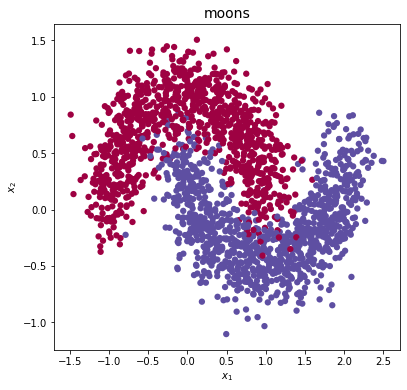

In [6]:
def load_dataset():
    # 采样点数
    N_SAMPLES = 2000
    # 测试数量比率
    TEST_SIZE = 0.3
    # 利用工具函数直接生成数据集
    X, y = make_moons(n_samples=N_SAMPLES, noise=0.2, random_state=100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)
    return X, y, X_train, X_test, y_train, y_test


def make_plot(X, y, plot_name, XX=None, YY=None, preds=None, dark=False):
    # 绘制数据集的分布，X为2D坐标，y为数据点的标签
    if (dark):
        plt.style.use('dark_background')
    plt.figure(figsize=(8, 6))
    axes = plt.gca()
    axes.set(xlabel="$x_1$", ylabel="$x_2$")
    plt.title(plot_name, fontsize=14)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if XX is not None and YY is not None and preds is not None:
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha=1, cmap=plt.cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    # 绘制散点图，根据标签区分颜色
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='none')
    plt.show()

X, y, X_train, X_test, y_train, y_test = load_dataset()
make_plot(X, y, "moons")

### 7.9.2 网络层
`Layer类`实现一个网络层：

In [7]:
# 全连接网络层
class Layer:
    def __init__(self, n_input, n_neurons, activation=None, weights=None, bias=None):
        # 通过正态分布初始化网络权值，初始化非常重要，不合适的初始化将导致网络不收敛
        self.weights = weights if weights is not None else np.random.randn(n_input,n_neurons)*np.sqrt(1/n_neurons)
        self.bias = bias if bias is not None else np.random.rand(n_neurons)*0.1
        self.activation = activation
        self.last_activation = None  # 激活函数的输出值o
        self.error = None  # 用于计算当前层的delta变量的中间变量
        self.delta = None  # 记录当前层的delta变量，用于计算梯度

    # 网络层的前向传播函数实现如下，其中last_activation变量用于保存当前层的输出值：
    def activate(self, x):
        # 前向传播函数, X@W+b
        r = np.dot(x, self.weights) + self.bias  
        # 通过激活函数，得到全连接层的输出o
        self.last_activation = self._apply_activation(r)
        return self.last_activation

    # self._apply_activation函数实现了不同类型的激活函数的前向计算过程
    def _apply_activation(self, r):
        # 计算激活函数的输出
        if self.activation is None:
            return r
        elif self.activation == 'relu':
            return np.maximum(r, 0)
        elif self.activation == 'tanh':
            return np.tanh(r)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-r))
        return r

    # 针对于不同类型的激活函数，它们的导数计算实现如下：
    def apply_activation_derivative(self, r):
        # 无激活函数，导数为1
        if self.activation is None:
            return np.ones_like(r)
        # ReLU函数的导数实现
        elif self.activation == 'relu':
            grad = np.array(r, copy=True)
            grad[r > 0] = 1.
            grad[r <= 0] = 0.
            return grad
        # tanh函数的导数实现
        elif self.activation == 'tanh':
            return 1 - r ** 2
        # Sigmoid函数的导数实现
        elif self.activation == 'sigmoid':
            return r * (1 - r)
        return r

### 7.9.3 网络模型
`NeuralNetwork`类内部维护各层的网络层`Layer`类对象：

In [8]:
# 神经网络模型
class NeuralNetwork:
    def __init__(self):
        self._layers = []

    def add_layer(self, layer):
        self._layers.append(layer)

    # 网络的前向传播只需要循环调各个网络层对象的前向计算函数即可
    def feed_forward(self, X):
        for layer in self._layers:
            X = layer.activate(X)
        return X
    
    # 反向传播算法实现
    def backpropagation(self, X, y, learning_rate):
        # 前向计算，得到输出值
        output = self.feed_forward(X)
        for i in reversed(range(len(self._layers))):  # 反向循环
            layer = self._layers[i]  # 得到当前层对象
            # 如果是输出层
            if layer == self._layers[-1]:
                layer.error = y - output  # 计算2分类任务的均方差的导数
                # 关键步骤：计算最后一层的delta，参考输出层的梯度公式
                layer.delta = layer.error * layer.apply_activation_derivative(output)
            else:  # 如果是隐藏层
                next_layer = self._layers[i + 1]  # 得到下一层对象
                layer.error = np.dot(next_layer.weights, next_layer.delta)
                # 关键步骤：计算隐藏层的delta，参考隐藏层的梯度公式
                layer.delta = layer.error * layer.apply_activation_derivative(layer.last_activation)

        # 循环更新权值
        for i in range(len(self._layers)):
            layer = self._layers[i]
            # o_i为上一网络层的输出
            o_i = np.atleast_2d(X if i == 0 else self._layers[i - 1].last_activation)
            # 梯度下降算法，delta是公式中的负数，故这里用加号
            layer.weights += layer.delta * o_i.T * learning_rate

    def train(self, X_train, X_test, y_train, y_test, learning_rate, max_epochs):
        y_onehot = np.zeros((y_train.shape[0], 2))
        y_onehot[np.arange(y_train.shape[0]), y_train] = 1
        # 将Onehot编码后的真实标签与网络的输出计算均方误差，并调用反向传播函数更新网络参数，循环迭代训练集1000遍即可
        mses = []
        accuracys = []
        for i in range(max_epochs + 1):  # 训练1000 个epoch
            for j in range(len(X_train)):  # 一次训练一个样本
                self.backpropagation(X_train[j], y_onehot[j], learning_rate)
            if i % 100 == 0:
                # 打印出MSE Loss
                mse = np.mean(np.square(y_onehot - self.feed_forward(X_train)))
                mses.append(mse)
                accuracy = self.accuracy(self.predict(X_test), y_test.flatten())
                accuracys.append(accuracy)
                print('Epoch: #%s, MSE: %f' % (i, float(mse)))
                # 统计并打印准确率
                print('Accuracy: %.2f%%' % (accuracy * 100))
        return mses, accuracys

    def predict(self, X):
        return self.feed_forward(X)

    def accuracy(self, X, y):
        return np.sum(np.equal(np.argmax(X, axis=1), y)) / y.shape[0]

训练模型：

Epoch: #0, MSE: 0.250198
Accuracy: 49.50%
Epoch: #100, MSE: 0.096040
Accuracy: 88.83%
Epoch: #200, MSE: 0.095081
Accuracy: 88.83%
Epoch: #300, MSE: 0.092835
Accuracy: 89.17%
Epoch: #400, MSE: 0.090202
Accuracy: 89.83%
Epoch: #500, MSE: 0.083936
Accuracy: 92.00%
Epoch: #600, MSE: 0.079681
Accuracy: 92.83%
Epoch: #700, MSE: 0.060048
Accuracy: 95.50%
Epoch: #800, MSE: 0.034868
Accuracy: 96.33%
Epoch: #900, MSE: 0.029502
Accuracy: 97.00%
Epoch: #1000, MSE: 0.027350
Accuracy: 97.00%


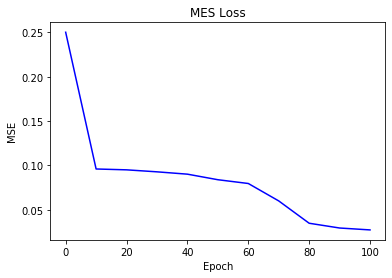

In [9]:
X, y, X_train, X_test, y_train, y_test = load_dataset()

nn = NeuralNetwork()  # 实例化网络类
nn.add_layer(Layer(2, 25, 'sigmoid'))  # 隐藏层 1, 2=>25
nn.add_layer(Layer(25, 50, 'sigmoid'))  # 隐藏层 2, 25=>50
nn.add_layer(Layer(50, 25, 'sigmoid'))  # 隐藏层 3, 50=>25
nn.add_layer(Layer(25, 2, 'sigmoid'))  # 输出层, 25=>2
mses, accuracys = nn.train(X_train, X_test, y_train, y_test, 0.01, 1000)

x = [i for i in range(0, 101, 10)]
# 绘制MES曲线
plt.title("MES Loss")
plt.plot(x, mses[:11], color='blue')
plt.xlabel('Epoch')
plt.ylabel('MSE')
# plt.savefig('训练误差曲线.svg')
plt.show()

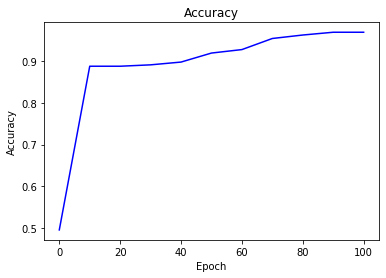

In [10]:
# 绘制Accuracy曲线
plt.title("Accuracy")
plt.plot(x, accuracys[:11], color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.savefig('网络测试准确率.svg')
plt.show()